We will be implementing a CNN from scratch heere using just Numpy. Here, I will keep the entire evolution of code until we get a final, polished CNN architecture. This way, we can understand the problems and implementations in a chronological way. 

In [ ]:
import numpy as np
import itertools

In [320]:
#Define the fundamentals of CNN:

#Take W size Input Image.
#Use a filter of size K.
#Return output of size W-k+1 (No Padding, No Stride).
#We will use and understand Padding & Stride as we progress into bottlenecks and more complex problems. 
#The main task here is to develop algorithm to convolute the filter through the image.

class con2d:
    def __init__(self, w, k):
        self.W = w
        self.K = k
        self.filter = np.random.rand(k,k)
        self.bias = random.uniform(-1,1)

    def forward(self, X):
        sum = 0
        Y = np.zeros((self.W + 1 - self.K, self.W + 1 - self.K))
        for i in range(self.W + 1 - self.K):
            for j in range(self.W + 1 - self.K):
                patch = X[i:i+self.K, j:j+self.K]
                for a in range(self.K):
                    for b in range(self.K):
                        sum += patch[a,b] * self.filter[a,b]
                #sum += self.bias
                #sum = np.tanh(sum)
                Y[i,j] = sum
                sum = 0
        return Y

In [321]:
input_image = np.array([
    [1, 1, 1, 0, 0],
    [0, 1, 1, 1, 0],
    [0, 0, 1, 1, 1],
    [0, 0, 1, 1, 0],
    [0, 1, 1, 0, 0]
])

kernel = np.array([
    [1, 0, -1],
    [1, 0, -1],
    [1, 0, -1]
])

myCNN = con2d(5,3)
myCNN.filter = kernel
myCNN.forward(input_image)

array([[-2.,  0.,  2.],
       [-3., -2.,  2.],
       [-3., -1.,  2.]])

This was an extremely inefficient implementation but we did get correct outcome. For now lets focus on the fact that CNNs work on rgb data which has 3 channels. But our code assumes an image as a flat 2D surface. We have to add depth/channel to our input matrix and thus our kernel. But importantly, our output matrix/activation map must remain the same.

In [322]:
class con2d:
    def __init__(self, w, k, c):
        self.W = w
        self.K = k
        self.C = c #Channel
        self.filter = np.random.rand(k,k,c)
        self.bias = random.uniform(-1,1)

    def forward(self, X):
        sum = 0
        Y = np.zeros((self.W + 1 - self.K, self.W + 1 - self.K))
        for i in range(self.W + 1 - self.K):
            for j in range(self.W + 1 - self.K):
                patch = X[i:i+self.K, j:j+self.K, :]
                for a in range(self.K):
                    for b in range(self.K):
                        for c in range(self.C):
                            sum += patch[a,b,c] * self.filter[a,b,c]
                #sum += self.bias
                #sum = np.tanh(sum)
                Y[i,j] = sum
                sum = 0
        return Y

In [323]:
input_vol = np.zeros((4, 4, 2))
input_vol[:, :, 0] = 1
input_vol[:, :, 1] = 2

kernel = np.zeros((3, 3, 2))
kernel[:, :, 0] = 1
kernel[:, :, 1] = -1

myCNN = con2d(4,3,2)
myCNN.filter = kernel
myCNN.forward(input_vol)

array([[-9., -9.],
       [-9., -9.]])

In [324]:
#To make this complete, lets uncomment bias application and let's try to have more than one filters.
class con2d:
    def __init__(self, w, k, c, n):
        self.W = w
        self.K = k
        self.C = c #Channels
        self.Cn = n #Number of filters
        self.filters = [np.random.rand(k,k,c) for _ in range(n)]
        self.bias = [random.uniform(-1,1) for _ in range(n)]

    def forward(self, X):
        sums = np.zeros(self.Cn)
        Y = [np.zeros((self.W + 1 - self.K, self.W + 1 - self.K)) for _ in range(self.Cn)]
        for i in range(self.W + 1 - self.K):
            for j in range(self.W + 1 - self.K):
                patch = X[i:i+self.K, j:j+self.K, :]
                for a in range(self.K):
                    for b in range(self.K):
                        for c in range(self.C):
                            for index, filter in enumerate(self.filters):
                                sums[index] += patch[a,b,c] * filter[a,b,c]
                for idx, sum in enumerate(sums):
                    sum += self.bias[idx]
                    #sum = np.tanh(sum)
                    Y[idx][i,j] = sum
                    sum = 0
        return Y

But these nested loops are extremely inefficient. We have to adress this. Modern libraries like pytorch and tensorflow use a standard practice called "im2col" where the entire image is stretched into a single vector arranged by the filter size. One way is to then also dilate our filter adding zeros in between such that a single matrix multiplication will simulate the filter being slid over the image. 

This however, would be inefficient. Why? We aren't using multiple nested loops which significantly improve performance. But, we are doing unecessarily large matrix multiplication involving 0 elements.


Best and SoTA practice is to flatten the image locally. I.e. we flatten only the receptive field of the kernel eg. 3x3x3, and then matmul it with our flattened kernel(3x3x3). This results in matmul between a 1x27 image and 27x1 kernel, resulting in a single scalar value. This scalar corresponds to a single pixel of the activation map after being added to the scalar bias term.

Let's take an example. Start from inputs of dimension 16x3x32x32 where 16 is the batch size, 3 is the number of channels and 32x32 is the image size. So we have 16 rgb images of 32x32 resolution as input each batch. Consider a kernel size of 128x3x2x2 where 128 is the number of kernels, 3 represents rgb and 3x3 is the kernel size. 

How does im2col work in this case? 

Firstly, calculate the receptive field size or the output field size.

O = ((I - K + 2P)/S) + 1

This is the standard formula where:
- I : Input image size (eg. 32x32)
- K : Kernel size (eg. 3x3)
- P : Zero Padding size (eg. 0 or 1 if we want O to be 32 = I)
- S : Stride (eg. 1)
- O : Output Activation size

Here, 

O = ((32-3+0)/1) + 1 = 30

So we get activation map of 30x30 per kernel.

If we want the activation map to be same size of that of input, we have to introduce padding: Specifically same padding. 

In our example, same padding requires padding = 1

Therefore we get, O = ((32-3+2)/1) + 1 = 32

For now, let us assume the initial case with no Padding. 

## Im2col Transformation Step-by-Step

### Given:
- Input: (16, 3, 32, 32) - 16 batches, 3 channels, 32×32 images
- Kernels: (128, 3, 3, 3) - 128 output channels/kernels/activation maps, 3 input channels, 3×3 spatial
- Output size: O = ((32 - 3 + 0) / 1) + 1 = **30×30**

### Step 1: Extract All Receptive Fields

For each image in the batch:
- Each receptive field: 3×3×3 = **27 elements**
- Number of positions: 30×30 = **900 positions**
- Total number of flattened matrices that represent all positions: **(900, 27)** (But this flatenning requires special handling so that we differentiate from 27 contigious memory of the image, and 27 neighbouring pixels that constitute a receptive field.)

For the entire batch (16 images):
- We stack all of them vertically (16 × 900, 27) = **(14,400, 27)**

### Step 2: Flatten All 128 Kernels

- Each kernel: 3×3×3 = 27 elements
- Kernels shape: **(27, 128)**

Why? 27 weights for each 128 kernels. 

### Step 3: Giant MatMul

(14,400, 27) @ (27, 128) = **(14,400, 128)**

### Step 4: Reshape and Add Bias

Reshape (14,400, 128) → (16, 128, 30, 30)
Add bias (128,) → broadcasts to (16, 128, 30, 30)


## So lets draw some conclusions first!

1. We need special type of matrix flatenning such that all pixels of local receptive fields(3x3x3 = 27) are in one dimension(x, 27) and all such local receptive fields(30x30 = 900) are in another, batch dimension(900, x) which represents the number of such possible receptive fields. This corresponds to number of pixels in activation map. Finally we need to consider all the receptive fields of all images in the batch. This doesnot create new dimension (not, eg. 16x900x27), but we stack all the receptive fields of all the images vertically. (i.e 900x16 = 14,400). Therefore we get final flatenned 2D matrix of shape = 14400, 27.

    ## Therefore:
    Local receptive field pixels must be arranged non contigiously relative to the image.

    eg.

    11  12  13

    21  22  23

    31  32  33

    should not be flattened as: 

    [11, 12, 13, 14],
        
    [13, 21, 22, 23], 


    [22, 23, 31, 32], 

    [31, 32, 33, 11] 

    Shape(4x4)

    or,

    [1,2,3,4,5,6,7,8,9] : Shape (9)

    But as:
    
    [11, 12, 21, 22],

    [12, 13, 22, 23],

    [21, 22, 23, 31],

    [22, 23, 32, 33]

    Shape(4x4)


2. To define our convolution layer, we need to know some parameters:
- Depth/No. of Channels of Kernel which corresponds to input channels(in_channels)
- Depth/No. of Channels of Activation/Output which corresponds to number of kernels (out_channels)
- Kernel size (kernel_size eg.(2) -> 2x2) 

In [325]:
class tensor:
    def __init__(self, fromArray=np.zeros((2,2)), _children = (), _operation = ''):
        fromArray = fromArray if isinstance(fromArray, np.ndarray) else np.array(fromArray)
        #assert len(fromArray.shape) == 2, "Only 2D Tensors or Scalar to 2D Supported!"
        self.matrix = fromArray
        #self.rows = fromArray.shape[0]
        #self.columns = fromArray.shape[1]
        self.shape = fromArray.shape
        self._prev = set(_children)
        self._operation = _operation
        self._backward = lambda : None
        self.grad = None


    def __repr__(self):
        return f"Tensor Values = {self.matrix}"
    
    @classmethod
    def zeros(cls, shape, dtype = np.float32):
        t = tensor()
        t.matrix = np.zeros(shape, dtype=dtype)
        t.shape = shape
        return t
    
    @classmethod
    def random(cls, shape, dtype = np.float32):
        t = tensor()
        t.matrix = (np.random.randn(*shape) * 0.1).astype(dtype=dtype)
        t.shape = shape
        return t
    
    @classmethod
    def he_init(cls, shape, fan_in, dtype=np.float32):
        t = tensor()
        std = np.sqrt(2.0 / fan_in)
        t.matrix = (np.random.randn(*shape) * std).astype(dtype=dtype)
        t.shape = shape
        return t
    
    @classmethod
    def const(cls, shape, constant=1, dtype = np.float32):
        t = tensor()
        t.matrix = (np.full(shape, constant)).astype(dtype=dtype)
        t.shape = shape
        return t
    
    #Operations
    def __add__(self, other):
        other = self.checkOther(other)
        out_matrix = self.matrix + other.matrix

        def _backward():
            self.grad = np.zeros_like(self.matrix) if self.grad is None else self.grad
            other.grad = np.zeros_like(other.matrix) if other.grad is None else other.grad
            out1 = self.return_unbroadcasted(out)
            out2 = other.return_unbroadcasted(out)
            self.grad += out1 #Derivation in the notes. 
            other.grad += out2
        out = tensor(out_matrix, (self, other), '+')
        out._backward = _backward
        return out
    
    def __radd__(self, other):
        return self + other
    
    def __sub__(self, other):
        other = self.checkOther(other)
        return self + (-1 * other)
    
    
    def __rsub__(self, other):
        other = self.checkOther(other)
        return other + (-1 * other)
    

    def __mul__(self, other):
        other = self.checkOther(other)
        out_matrix = self.matrix * other.matrix
        def _backward():
            self.grad = np.zeros_like(out.grad) if self.grad is None else self.grad
            other.grad = np.zeros_like(out.grad) if other.grad is None else other.grad
            out1 = self.return_unbroadcasted(out)
            out2 = other.return_unbroadcasted(out)
            self.grad += out1* other.matrix #Derivation in the notes. 
            other.grad += out2 * self.matrix

        out = tensor(out_matrix, (self, other), '*')
        out._backward = _backward
        return out
    
    def __rmul__(self, other):
        other = self.checkOther(other)
        return self*other
    
    '''
    batch multiplication might cause shape broadcasts.
    eg. (3,2,2) @ (1,2,3) = (3,2,3)
    this is similar to our element wise operations
    thus we should be handling this the same way we did for elementwise operations
    But, for now, we would be working in a controlled way (Even for CNNS)
    and wouldn't need this handling.
    '''
    def __matmul__(self, other):
        other = other if isinstance(other, tensor) else tensor(other)
        assert other.shape[-2] == self.shape[-1], "Dimension Unsupported for @"
        out_matrix = self.matrix @ other.matrix
        def _backward():
            self.grad = np.zeros_like(self.matrix) if self.grad is None else self.grad
            other.grad = np.zeros_like(other.matrix) if other.grad is None else other.grad
            self.grad += out.grad @ (other.matrix).swapaxes(-2,-1)#Derivation in the notes.
            other.grad += (self.matrix).swapaxes(-2,-1) @ out.grad 
        out = tensor(out_matrix, (self, other), '@')
        out._backward = _backward
        return out
    

    #I and thus we should learn at this point that to make our class compatible for ND tensors,
    #We need the matrix multiplication and Transpose backward to change
    #For higher dimensions, matmul = batch matmul where multiplication is done 
    #along each and every batches of 2D matrix. 
    #eg. If we have (2,3,3) shape tensor, it implies there are two batches of (3,3) matrices
    #similarly, (2,3,3,2) shape = 2x3 batches of 3x2 matrices.
    #matrix multiplication, (2,3,3) @ (2,3,2) = (2,3,2)
    def swap_axes(self, axis1, axis2):
        out_matrix = self.matrix.swapaxes(axis1, axis2)
        
        def _backward():
            self.grad = np.zeros_like(out.grad.swapaxes(axis1,axis2)) if self.grad is None else self.grad
            self.grad += (out.grad).swapaxes(axis1,axis2) #Not in note, but can be derived similarly.

        out = tensor(out_matrix, (self, ), 'T')
        out._backward = _backward

        return out

    def transpose(self):
        out_matrix = self.matrix.transpose()
        
        def _backward():
            self.grad = np.zeros_like(out.grad.transpose()) if self.grad is None else self.grad
            self.grad += (out.grad).transpose() #Not in note, but can be derived similarly.

        out = tensor(out_matrix, (self, ), 'T')
        out._backward = _backward

        return out
    
    def __rmatmul__(self, other):
        other = other if isinstance(other, tensor) else tensor(other)
        return other @ self
    
    def __pow__(self, N):
        assert isinstance(N, int | float), "Can only power up by scalars!"
        out_matrix = self.matrix ** N

        def _backward():
            self.grad = np.zeros_like(self.matrix) if self.grad is None else self.grad
            out1 = self.return_unbroadcasted(out)
            self.grad += N * (self.matrix ** (N-1)) * out1
        
        out = tensor(out_matrix, _children=(self, ), _operation="**")
        out._backward = _backward
        return out
    
    def __truediv__(self, other):
        other = self.checkOther(other)
        return self * (other**-1)
    
    def __rtruediv__(self, other):
        return other * (self**-1)
    
    def sum(self):
        out_matrix = np.array(([[self.matrix.sum()]]))

        def _backward():
            self.grad = np.zeros_like(self.matrix) if self.grad is None else self.grad
            self.grad += np.ones_like(self.matrix) * out.grad

        out = tensor(out_matrix, _children=(self, ), _operation='sum()')
        out._backward = _backward
        return out

    def mean(self):
        N = np.prod(self.shape)
        out_matrix = np.array(([[self.matrix.sum()/(N)]]))

        def _backward():
            self.grad = np.zeros_like(self.matrix) if self.grad is None else self.grad
            self.grad += np.ones_like(self.matrix) * out.grad / N

        out = tensor(out_matrix, _children=(self, ), _operation='mean()')
        out._backward = _backward
        return out
    
    def ReLU(self):
        out_matrix = np.maximum(0,self.matrix)

        def _backward():
            self.grad = np.zeros_like(self.matrix) if self.grad is None else self.grad
            self.grad += (self.matrix > 0).astype(self.matrix.dtype) * out.grad

        out = tensor(out_matrix, (self, ), "ReLU")
        out._backward = _backward
        return out
    
    def reshape(self, shape):
        assert isinstance(shape, tuple), f"Can only reshape using shape tuples e.g. (3,3). Provided is {shape}"
        out_matrix = self.matrix.reshape(shape)

        def _backward():
            self.grad = np.zeros_like(self.matrix) if self.grad is None else self.grad
            self.grad += out.grad.reshape(self.shape)

        out = tensor(out_matrix, (self, ), "reshape()")
        out._backward = _backward
        return out
    
    def flatten(self):
        out_matrix = self.matrix.reshape(-1,np.prod(self.shape[1:]))

        def _backward():
            self.grad = np.zeros_like(self.matrix) if self.grad is None else self.grad
            self.grad += out.grad.reshape(self.shape)

        out = tensor(out_matrix, (self, ), "flatten()")
        out._backward = _backward
        return out
    
    #Helper Functions
    #def shape(self):
     #   return (self.rows, self.columns)

    def return_unbroadcasted(self, out):  
        added_axis = []
        stretched_axis = []
        for index, (first_no, second_no) in enumerate(itertools.zip_longest(reversed(self.shape), reversed(out.shape))):
            if first_no is None:
                added_axis.append(index)
            elif (first_no == 1) and (second_no > 1):
                stretched_axis.append(index)
        grad = out.grad
        ndim = len(out.shape)
        if stretched_axis:
            original_axes = tuple(ndim - 1 - i for i in stretched_axis)
            grad = np.sum(grad, axis=original_axes, keepdims=True)
        if added_axis:
            original_axes = tuple(ndim - 1 - i for i in added_axis)
            grad = np.sum(grad, axis=original_axes, keepdims=False)
        return grad

    def checkOther(self, other):
        if isinstance(other, int | float):
            other = tensor.const(self.shape, other)
        elif not isinstance(other, tensor):
            other = tensor(other)
        #assert other.shape == self.shape, "Operand Tensor sizes dont match"

        return other
    
    def zero_grad(self):
        self.grad = None
        
    def backward(self):
        self.grad = np.ones_like(self.matrix, dtype=float)
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        for current in reversed(topo):

            current._backward()

    def exp(self):
        out_matrix = np.exp(self.matrix)
        
        def _backward():
            self.grad = np.zeros_like(self.matrix) if self.grad is None else self.grad
            self.grad += out_matrix * out.grad  
        
        out = tensor(out_matrix, (self,), 'exp')
        out._backward = _backward
        return out
    
    def log(self, eps=1e-8):
        clipped = np.clip(self.matrix, eps, None)  
        out_matrix = np.log(clipped)
        
        def _backward():
            self.grad = np.zeros_like(self.matrix) if self.grad is None else self.grad
            self.grad += (1.0 / clipped) * out.grad 
        
        out = tensor(out_matrix, (self,), 'log')
        out._backward = _backward
        return out
    
    def softmax(self, axis=-1):
        out_matrix = np.exp(self.matrix) / np.sum(np.exp(self.matrix), axis = axis, keepdims=True)

        def _backward():
            self.grad = np.zeros_like(self.matrix) if self.grad is None else self.grad
            self.grad += out_matrix*(out.grad - np.sum(out_matrix * out.grad, axis = axis, keepdims=True))

        out = tensor(out_matrix, (self, ), 'softmax')
        out._backward = _backward
        return out

    __array_ufunc__ = None

In [326]:
class Conv2d:
    def __init__(self, in_channels, out_channels, kernel_size):
        self.kernel = tensor.random((out_channels, in_channels, kernel_size, kernel_size))

    @classmethod
    def im2col(cls, X : tensor, kernel_size, stride):

        batch_size = X.shape[0]
        channels = X.shape[1]
        image_height = X.shape[-2] #Rows
        image_width = X.shape[-1] #Columns


        #We are assuming square kernels.
        kernel_h = kernel_size
        kernel_w = kernel_size

        act_h = (((image_height - kernel_size)//stride) + 1) #height of activation
        act_w = (((image_width - kernel_size)//stride) + 1)  #width of activation

        istrides = X.matrix.strides #strides of input tensor

        intermediate_6D = np.lib.stride_tricks.as_strided(
                            X.matrix,
                            shape=(batch_size, act_h, act_w, channels, kernel_h, kernel_w),
                            strides=(istrides[0], #No of images stride bytes
                                     istrides[-2] * stride, #Activation map Vertical stride bytes
                                     istrides[-1] * stride, #Activation map Horizontal stride bytes
                                     istrides[1], #Channel stride bytes
                                     istrides[-2], #Rective field vertical stride bytes
                                     istrides[-1]) #Receptive field horizontal stride bytes
                            )
        
        out_shape = (batch_size * act_h * act_w, channels * kernel_h * kernel_w)
        out_matrix = np.reshape(intermediate_6D, shape=out_shape)


        def _backward():
            X.grad = np.zeros_like(X.matrix) if X.grad is None else X.grad
            grad_6D = np.reshape(out.grad, shape=(batch_size, act_h, act_w, channels, kernel_h, kernel_w,))

            #For each element in this 6D tensor, having 6D index, we have to calculate the coresponding 4D index.
            #The formula has been conceptually derived in the notes.
            #Here, we first generate all the indices of the 6D tensor and store each index dimension in separate list
            #Then using the derived formula, we batch convert the 6D indices to 4D indices.

            batch = np.arange(batch_size).reshape(batch_size,1,1,1,1,1)
            field_h = np.arange(act_h).reshape(1,act_h,1,1,1,1)
            field_w = np.arange(act_w).reshape(1,1,act_w,1,1,1)
            channel = np.arange(channels).reshape(1,1,1,channels,1,1)
            k_h = np.arange(kernel_h).reshape(1,1,1,1,kernel_h,1)
            k_w = np.arange(kernel_w).reshape(1,1,1,1,1,kernel_w)

            x = stride * field_h + k_h
            y = stride * field_w + k_w

            np.add.at(X.grad, (batch, channel, x, y), grad_6D)

        out = tensor(out_matrix, _children=(X, ), _operation='im2col')
        out._backward = _backward

        return out
            

In [327]:
batch = tensor(np.random.randn(16, 3, 5, 5).astype(float))

print("Input Shape: ", batch.shape)

im2col = Conv2d.im2col(batch, 3, 2)

print("Output Shape: ", im2col.shape)

Input Shape:  (16, 3, 5, 5)
Output Shape:  (64, 27)


This was a valid approach. Elegant and shows the direct use of formula. But, we have an even more efficient approach. It involves slicing. In this method, instead of creating large index array which requires both time and memory, we can call 2 simple for loops to loop over the kernel sizes and slice the out.grad array for each position of the kernel index.

In [328]:
class Conv2d:
    def __init__(self, in_channels=1, out_channels=1, kernel_size=2):
        self.kernel = tensor.random((out_channels, in_channels, kernel_size, kernel_size))
        self.bias = tensor.random((out_channels, ))
        self.kernel_size = kernel_size
        self.out_channels = out_channels
        self.in_channels = in_channels

    def __call__(self, X : tensor, stride=1):

        batch_size = X.shape[0]

        X_col, act_h, act_w = Conv2d.im2col(X, kernel_size=self.kernel_size, stride=stride)
        K_col_shape = (self.out_channels, self.kernel_size*self.kernel_size*self.in_channels)
        K_col = self.kernel.reshape(K_col_shape).transpose()
        Y_col = X_col @ K_col + self.bias
        Y = Y_col.reshape((batch_size, self.out_channels, act_h, act_w))
        pooled = Conv2d.maxpool2d(Y)
        return pooled
        
    @classmethod
    def im2col(cls, X : tensor, kernel_size=2, stride=1):

        batch_size = X.shape[0]
        channels = X.shape[1]
        image_height = X.shape[-2] #Rows
        image_width = X.shape[-1] #Columns


        #We are assuming square kernels.
        kernel_h = kernel_size
        kernel_w = kernel_size

        act_h = (((image_height - kernel_size)//stride) + 1) #height of activation
        act_w = (((image_width - kernel_size)//stride) + 1)  #width of activation

        istrides = X.matrix.strides #strides of input tensor

        intermediate_6D = np.lib.stride_tricks.as_strided(
                            X.matrix,
                            shape=(batch_size, act_h, act_w, channels, kernel_h, kernel_w),
                            strides=(istrides[0], #No of images stride bytes
                                     istrides[-2] * stride, #Activation map Vertical stride bytes
                                     istrides[-1] * stride, #Activation map Horizontal stride bytes
                                     istrides[1], #Channel stride bytes
                                     istrides[-2], #Rective field vertical stride bytes
                                     istrides[-1]) #Receptive field horizontal stride bytes
                            )
        
        out_shape = (batch_size * act_h * act_w, channels * kernel_h * kernel_w)
        out_matrix = np.reshape(intermediate_6D, shape=out_shape)


        def _backward():
            X.grad = np.zeros_like(X.matrix) if X.grad is None else X.grad
            
            grad_6D = out.grad.reshape(batch_size, act_h, act_w, channels, kernel_h, kernel_w)

            for i in range(kernel_h):
                for j in range(kernel_w):
                    grad_slice = grad_6D[:, :, :, :, i, j]
                    
                    grad_slice_transposed = grad_slice.transpose(0, 3, 1, 2)
                    
                    X.grad[:, :, 
                        i : i + act_h * stride : stride, 
                        j : j + act_w * stride : stride
                    ] += grad_slice_transposed

        out = tensor(out_matrix, _children=(X, ), _operation='im2col')

        out._backward = _backward

        return out, act_h, act_w
    
    @classmethod
    def maxpool2d(cls, Y: tensor, pool_size=2, stride=1):   
        batch_number = Y.shape[0]
        filters = Y.shape[1]
        image_height = Y.shape[-2] #Rows
        image_width = Y.shape[-1] #Columns


        #We are assuming square kernels.
        pool_h = pool_size
        pool_w = pool_size

        pooled_h = (((image_height - pool_h)//stride) + 1) #height of activation
        pooled_w = (((image_width - pool_w)//stride) + 1)  #width of activation

        istrides = Y.matrix.strides #strides of input tensor

        intermediate_6D = np.lib.stride_tricks.as_strided(
                            Y.matrix,
                            shape=(batch_number, pooled_h, pooled_w, filters, pool_h, pool_w),
                            strides=(istrides[0], #No of images stride bytes
                                     istrides[-2] * stride, #Activation map Vertical stride bytes
                                     istrides[-1] * stride, #Activation map Horizontal stride bytes
                                     istrides[1], #Channel stride bytes
                                     istrides[-2], #Rective field vertical stride bytes
                                     istrides[-1]) #Receptive field horizontal stride bytes
                            )
        
        intermediate_5D = np.reshape(intermediate_6D, (batch_number, filters, pooled_h, pooled_w, pool_h * pool_w))


        out_matrix = np.max(intermediate_5D, axis = -1)
        IndexA_for5D = np.argmax(intermediate_5D, axis = -1)

        def _backward():
            # Recover window position (i, j) from flat index in last dim
            Y.grad = np.zeros_like(Y.matrix) if Y.grad is None else Y.grad
            flat_idx = IndexA_for5D  # (B, F, pooled_h, pooled_w)
            i = flat_idx // pool_w
            j = flat_idx % pool_w

            # Build grids for batch, filter, and pooled positions
            b_grid = np.arange(batch_number).reshape(batch_number, 1, 1, 1)
            f_grid = np.arange(filters).reshape(1, filters, 1, 1)
            ph_grid = np.arange(pooled_h).reshape(1, 1, pooled_h, 1)
            pw_grid = np.arange(pooled_w).reshape(1, 1, 1, pooled_w)

            # Broadcast all to shape (B, F, pooled_h, pooled_w)
            b_idx = np.broadcast_to(b_grid, flat_idx.shape)
            f_idx = np.broadcast_to(f_grid, flat_idx.shape)
            ph = np.broadcast_to(ph_grid, flat_idx.shape)
            pw = np.broadcast_to(pw_grid, flat_idx.shape)

            # Compute actual positions in Y where max values came from
            h_idx = stride * ph + i
            w_idx = stride * pw + j

            # Accumulate gradients using 4D indexing
            np.add.at(Y.grad, (b_idx.ravel(), f_idx.ravel(), h_idx.ravel(), w_idx.ravel()), out.grad.ravel())

        out = tensor(out_matrix, _children=(Y, ), _operation="maxpool")
        out._backward = _backward

        return out


                



In [329]:
# Test im2col gradient via Conv2d layer
X = tensor(np.random.randn(1, 1, 4, 4))
layer = Conv2d(in_channels=1, out_channels=1, kernel_size=2)
Y = layer(X, stride=1)
Y.backward()
print("Input gradient:\n", X.grad[0, 0])

Input gradient:
 [[ 0.          0.16558826  0.26603022  0.        ]
 [ 0.         -0.12948838 -0.21422252  0.13301511]
 [ 0.08279413  0.13301511 -0.06474419 -0.14850833]
 [-0.06474419 -0.14850833  0.          0.        ]]


In [330]:
numbers = np.random.random_integers(0,16, 16)
Y = numbers.reshape(16,1)
act_h = 4
act_w = 4
istrides = Y.strides
istrides

/var/folders/vx/0mwc7nyn64x7k2f0jlg9hs300000gn/T/ipykernel_4904/2651310694.py:1: DeprecationWarning: This function is deprecated. Please call randint(0, 16 + 1) instead
  numbers = np.random.random_integers(0,16, 16)


(8, 8)

In [331]:
# Test maxpool gradient via Conv2d layer
X = tensor(np.random.randn(1, 1, 4, 4))
layer = Conv2d(in_channels=1, out_channels=1, kernel_size=2)
Y = layer(X, stride=1)
Y.backward()
print("Input gradient:\n", X.grad[0, 0])

Input gradient:
 [[ 0.          0.          0.          0.        ]
 [ 0.19496737  0.31884017  0.12387279  0.        ]
 [ 0.13988314  0.32095182  0.18106868  0.        ]
 [-0.05508423  0.00211165  0.05719589  0.        ]]


In [332]:
class Conv2d:
    def __init__(self, in_channels=1, out_channels=1, kernel_size=2, stride=1):
        self.kernel = tensor.random((out_channels, in_channels, kernel_size, kernel_size))
        #fan_in = in_channels * kernel_size * kernel_size
        #self.kernel = tensor.he_init((out_channels, in_channels, kernel_size, kernel_size), fan_in)
        self.bias = tensor.zeros((out_channels, ))
        self.kernel_size = kernel_size
        self.out_channels = out_channels
        self.in_channels = in_channels
        self.stride = stride

    def parameters(self):
        return [self.kernel, self.bias]

    def __call__(self, X : tensor):

        batch_size = X.shape[0]

        X_col, act_h, act_w = Conv2d.im2col(X, kernel_size=self.kernel_size, stride=self.stride)
        K_col_shape = (self.out_channels, self.kernel_size*self.kernel_size*self.in_channels)
        K_col = self.kernel.reshape(K_col_shape).transpose()
        Y_col = X_col @ K_col + self.bias
        Y = Y_col.reshape((batch_size, self.out_channels, act_h, act_w))
        return Y
        
    @classmethod
    def im2col(cls, X : tensor, kernel_size=2, stride=1):

        batch_size = X.shape[0]
        channels = X.shape[1]
        image_height = X.shape[-2] #Rows
        image_width = X.shape[-1] #Columns

        #We are assuming square kernels.
        kernel_h = kernel_size
        kernel_w = kernel_size

        act_h = (((image_height - kernel_size)//stride) + 1) #height of activation
        act_w = (((image_width - kernel_size)//stride) + 1)  #width of activation

        istrides = X.matrix.strides #strides of input tensor

        intermediate_6D = np.lib.stride_tricks.as_strided(
                            X.matrix,
                            shape=(batch_size, act_h, act_w, channels, kernel_h, kernel_w),
                            strides=(istrides[0], #No of images stride bytes
                                     istrides[-2] * stride, #Activation map Vertical stride bytes
                                     istrides[-1] * stride, #Activation map Horizontal stride bytes
                                     istrides[1], #Channel stride bytes
                                     istrides[-2], #Rective field vertical stride bytes
                                     istrides[-1]) #Receptive field horizontal stride bytes
                            )
        
        out_shape = (batch_size * act_h * act_w, channels * kernel_h * kernel_w)
        out_matrix = np.reshape(intermediate_6D, shape=out_shape)


        def _backward():
            X.grad = np.zeros_like(X.matrix) if X.grad is None else X.grad
            
            grad_6D = out.grad.reshape(batch_size, act_h, act_w, channels, kernel_h, kernel_w)
            for i in range(kernel_h):
                for j in range(kernel_w):
                    grad_slice = grad_6D[:, :, :, :, i, j]
                    
                    grad_slice_transposed = grad_slice.transpose(0, 3, 1, 2)
                    X.grad[:, :, 
                        i : i + act_h * stride : stride, 
                        j : j + act_w * stride : stride
                    ] += grad_slice_transposed

        out = tensor(out_matrix, _children=(X, ), _operation='im2col')

        out._backward = _backward

        return out, act_h, act_w

In [333]:
class maxpool2D:
    def __init__(self, in_channels, pool_size = 2, stride = 1):
        self.in_channels = in_channels
        self.pool_size = pool_size
        self.stride = stride


    def __call__(self, Y: tensor):

        batch_number = Y.shape[0]
        filters = Y.shape[1]
        image_height = Y.shape[-2] #Rows
        image_width = Y.shape[-1] #Columns


        #We are assuming square kernels.
        pool_h = self.pool_size
        pool_w = self.pool_size

        pooled_h = (((image_height - pool_h)//self.stride) + 1) #height of activation
        pooled_w = (((image_width - pool_w)//self.stride) + 1)  #width of activation

        istrides = Y.matrix.strides #strides of input tensor

        intermediate_6D = np.lib.stride_tricks.as_strided(
                            Y.matrix,
                            shape=(batch_number, pooled_h, pooled_w, filters, pool_h, pool_w),
                            strides=(istrides[0], #No of images stride bytes
                                     istrides[-2] * self.stride, #Activation map Vertical stride bytes
                                     istrides[-1] * self.stride, #Activation map Horizontal stride bytes
                                     istrides[1], #Channel stride bytes
                                     istrides[-2], #Rective field vertical stride bytes
                                     istrides[-1]) #Receptive field horizontal stride bytes
                            )
        
        intermediate_6D_transposed = intermediate_6D.transpose(0, 3, 1, 2, 4, 5)
        intermediate_5D = intermediate_6D_transposed.reshape(batch_number, filters, pooled_h, pooled_w, pool_h * pool_w)

        out_matrix = np.max(intermediate_5D, axis=-1)
        IndexA_for5D = np.argmax(intermediate_5D, axis=-1)

        def _backward():
            # Recover window position (i, j) from flat index in last dim
            Y.grad = np.zeros_like(Y.matrix) if Y.grad is None else Y.grad
            flat_idx = IndexA_for5D  # (B, F, pooled_h, pooled_w)
            i = flat_idx // pool_w
            j = flat_idx % pool_w

            # Build grids for batch, filter, and pooled positions
            b_grid = np.arange(batch_number).reshape(batch_number, 1, 1, 1)
            f_grid = np.arange(filters).reshape(1, filters, 1, 1)
            ph_grid = np.arange(pooled_h).reshape(1, 1, pooled_h, 1)
            pw_grid = np.arange(pooled_w).reshape(1, 1, 1, pooled_w)

            # Broadcast all to shape (B, F, pooled_h, pooled_w)
            b_idx = np.broadcast_to(b_grid, flat_idx.shape)
            f_idx = np.broadcast_to(f_grid, flat_idx.shape)
            ph = np.broadcast_to(ph_grid, flat_idx.shape)
            pw = np.broadcast_to(pw_grid, flat_idx.shape)

            # Compute actual positions in Y where max values came from
            h_idx = self.stride * ph + i
            w_idx = self.stride * pw + j

            # Accumulate gradients using 4D indexing
            np.add.at(Y.grad, (b_idx.ravel(), f_idx.ravel(), h_idx.ravel(), w_idx.ravel()), out.grad.ravel())

        out = tensor(out_matrix, _children=(Y, ), _operation="maxpool")
        out._backward = _backward

        return out

In [334]:
class FC:
    def __init__(self, in_features, out_features):
        
        self.bias = tensor.zeros((out_features, 1))
        # He initialization: fan_in = in_features
        #self.weights = tensor.he_init((out_features, in_features), in_features)
        self.weights = tensor.random((out_features, in_features))

    def parameters(self):
        return [self.weights, self.bias]

    def __call__(self, X:tensor):
        return (self.weights @ X) + self.bias

In [335]:
class CNN:
    def __init__(self, in_channels, layers, kernels_in_layers, kernels_shape, conv_strides, pool_shape, pool_strides, FCL_weights):

        self.FCL_weights = FCL_weights
        self.layers = layers
        self.conv_layers = [Conv2d(in_channels[layer], kernels_in_layers[layer], kernels_shape[layer], conv_strides[layer]) for layer in range(layers)]
        self.pool_layers = [maxpool2D(kernels_in_layers[layer], pool_shape[layer], pool_strides[layer]) for layer in range(layers)]
        self.FC_layers = [None for _ in range(layers+1)]

    def parameters(self):
        params = []
        for layer in range(self.layers):
            params.extend(self.conv_layers[layer].parameters())
            params.extend(self.FC_layers[layer].parameters())
        params.extend(self.FC_layers[layer+1].parameters())
        return params

    def __call__(self, X:tensor):
        b = X
        for layer in range(self.layers):
            a_ = self.conv_layers[layer](b)
            a = a_.ReLU()
            b = self.pool_layers[layer](a)
        
        c:tensor = b.reshape((X.shape[0], -1)).transpose()
        if self.FC_layers[0] is None:
            self.FC_layers[0] = FC(c.shape[0], self.FCL_weights[0])

        for layer in range(self.layers+1):
            if self.FC_layers[layer] is None:
                self.FC_layers[layer] = FC(self.FCL_weights[layer-1], self.FCL_weights[layer])

            c = self.FC_layers[layer](c)
            
            if layer < self.layers:
                c = c.ReLU()
        
        out = c.transpose()
        return out
    
    @classmethod
    def cross_entropy_loss(cls, ypredicted: tensor, ytrue, batch_size):
        ytrue =  tensor(ytrue) if not isinstance(ytrue, tensor) else ytrue
        ypredicted = ypredicted.softmax(axis=-1)
        cross_entropy = -1 * ypredicted.log()
        #loss = ((ytrue * cross_entropy).sum())/batch_size
        loss = ((ytrue * cross_entropy).sum())
        return loss

    def fit(self, X_train, y_train, epochs = 10, lr = 0.001, batch_size = 32):
        lossT = []
        for epoch in range(epochs):
            epoch_loss = 0.0
            n_batches = 0
            perm = np.random.permutation(len(X_train))
            for i in range(0, len(X_train), batch_size):
                idx = perm[i:i+batch_size]
                xb = tensor(X_train[idx])             
                yb = tensor(y_train[idx]) 

                y_predicted = self(xb)
                ce_loss = CNN.cross_entropy_loss(y_predicted, yb, len(idx))
                ce_loss.backward()

                for param in self.parameters():
                    if param.grad is not None:

                        grad_clipped = np.clip(param.grad, -1.0, 1.0)
                        param.matrix -= lr * grad_clipped
                        param.grad = None
                
                epoch_loss += ce_loss.matrix.flatten()[0]
                n_batches += 1
            
            avg_loss = epoch_loss / n_batches    
            print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.6f}")
            lossT.append((epoch, avg_loss))

        return lossT

In [336]:
X = tensor.random((4, 3, 32, 32))
c = CNN((3,5, ), 2, (5, 16, ), (5, 5, ), (1, 1, ), (2, 2, ), (1, 1, ), (128, 64, 10, ))
out = c(X)
print(out.shape)
out

(4, 10)


Tensor Values = [[ 1.37541    -0.17973997 -0.5400962  -0.3545546   2.3042114   0.67399174
  -1.4384911   0.89020795 -0.11354592  0.5103045 ]
 [ 1.0008098  -0.99008155 -0.56224483 -0.6605275   2.5096958   0.9243122
  -1.1521055   1.4019393  -0.77530885  0.655017  ]
 [ 1.0949072  -0.03747508 -0.3775244  -0.21293691  1.5070676   0.5822945
  -1.4455955   1.1064692  -0.1782994   0.9344257 ]
 [ 1.3523557  -0.34198967 -0.25011295 -0.42021936  1.9192302   0.7020867
  -1.3195586   1.1450962   0.47290972  0.6088739 ]]

In [337]:
import os
os.environ['KERAS_BACKEND'] = 'jax'
from keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = X_train[:, np.newaxis, :, :].astype(np.float32) / 255.0  
X_test = X_test[:, np.newaxis, :, :].astype(np.float32) / 255.0
Y_train = np.zeros((y_train.size, 10))
Y_train[np.arange(y_train.size), y_train] = 1
Y_test = np.zeros((y_test.size, 10))
Y_test[np.arange(y_test.size), y_test] = 1

Epoch 1/50, Loss: 67.764360
Epoch 2/50, Loss: 41.843807
Epoch 3/50, Loss: 24.200884
Epoch 4/50, Loss: 17.790467
Epoch 5/50, Loss: 12.652607
Epoch 6/50, Loss: 9.882604
Epoch 7/50, Loss: 7.376572
Epoch 8/50, Loss: 5.709124
Epoch 9/50, Loss: 4.334053
Epoch 10/50, Loss: 3.495332
Epoch 11/50, Loss: 1.782920
Epoch 12/50, Loss: 2.866913
Epoch 13/50, Loss: 1.205334
Epoch 14/50, Loss: 0.183684
Epoch 15/50, Loss: 0.485346
Epoch 16/50, Loss: 0.042181
Epoch 17/50, Loss: 0.014020
Epoch 18/50, Loss: 0.009922
Epoch 19/50, Loss: 0.007908
Epoch 20/50, Loss: 0.006635
Epoch 21/50, Loss: 0.005751
Epoch 22/50, Loss: 0.005063
Epoch 23/50, Loss: 0.004540
Epoch 24/50, Loss: 0.004113
Epoch 25/50, Loss: 0.003762
Epoch 26/50, Loss: 0.003483
Epoch 27/50, Loss: 0.003231
Epoch 28/50, Loss: 0.003011
Epoch 29/50, Loss: 0.002833
Epoch 30/50, Loss: 0.002668
Epoch 31/50, Loss: 0.002520
Epoch 32/50, Loss: 0.002391
Epoch 33/50, Loss: 0.002269
Epoch 34/50, Loss: 0.002167
Epoch 35/50, Loss: 0.002065
Epoch 36/50, Loss: 0.001

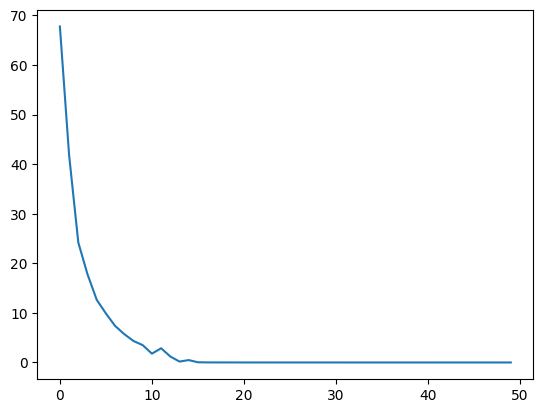


Final accuracy on 10 samples: 100.0%


In [338]:
c = CNN(
    in_channels=(1, 5),           
    layers=2,                      
    kernels_in_layers=(5, 16),    
    kernels_shape=(5, 5),         
    conv_strides=(1, 1),          
    pool_shape=(2, 2),            
    pool_strides=(2, 2),          
    FCL_weights=(128, 64, 10)     
)

loss = c.fit(X_train[:1000], Y_train[:1000], epochs=50, lr=0.01, batch_size=32)


import matplotlib.pyplot as plt
epochs, losses = zip(*loss)
plt.plot(epochs, losses)
plt.show()

# Check predictions
xtest = X_train[:10]
ytest = Y_train[:10]
ypred = c(tensor(xtest))
probs = ypred.softmax()
pred_classes = np.argmax(probs.matrix, axis=1)
true_classes = np.argmax(ytest, axis=1)
print(f"\nFinal accuracy on 10 samples: {(pred_classes == true_classes).mean() * 100:.1f}%")

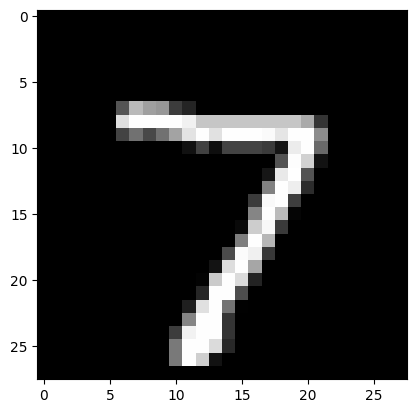

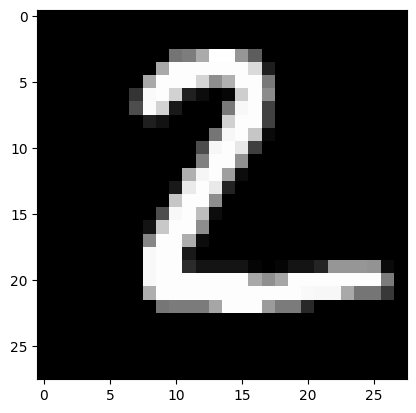

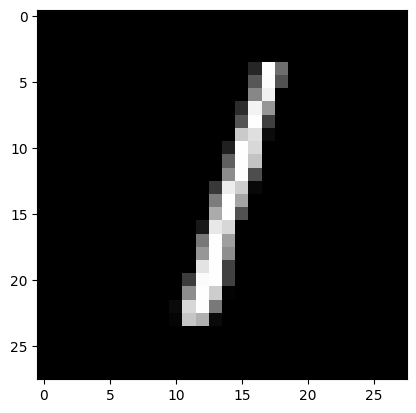

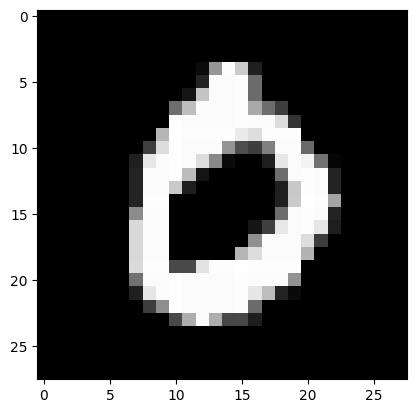

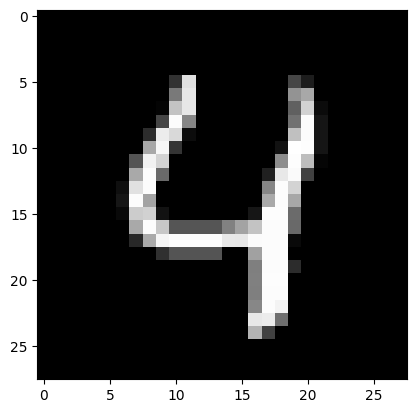

Predicted probabilities (first 5 samples):
[[1.0230549e-18 7.0430810e-20 6.2314222e-13 3.5229641e-10 5.3375937e-21
  8.9228779e-19 1.4081702e-22 1.0000000e+00 6.5325510e-17 4.9769276e-11]
 [8.9245589e-23 2.4616114e-15 9.9998730e-01 1.2728794e-05 1.6368996e-23
  4.2283898e-13 1.0870879e-17 1.0555706e-17 2.1653588e-15 1.6906847e-12]
 [7.4819955e-17 9.9999988e-01 1.6939473e-09 1.9417246e-12 2.4095977e-12
  6.2034003e-11 2.7658644e-09 1.6505093e-07 5.6863897e-10 4.7943611e-11]
 [9.9999803e-01 1.3376892e-12 2.0479758e-09 5.9814769e-19 2.9872658e-12
  2.4912999e-12 7.8027590e-08 1.2086272e-12 2.4329228e-15 1.8979005e-06]
 [2.3542042e-11 1.8774957e-10 1.7305004e-07 1.6683199e-12 9.9999475e-01
  5.8889305e-10 7.0282127e-08 1.5205998e-09 1.1045014e-09 4.8897332e-06]]

Actual labels (first 5 samples):
[[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]

Predicted classes: [7 2 1 0 4]

In [347]:
xtest = X_test[:5]
ytest = Y_test[:5]

for image in xtest:
    for channel in image:
        plt.imshow(channel, cmap='gray')
        plt.show()

ypred = c(tensor(xtest))
probs = ypred.softmax()

print("Predicted probabilities (first 5 samples):")
print(probs.matrix[:5])
print("Actual labels (first 5 samples):")
print(ytest[:5])

# Check argmax accuracy
pred_classes = np.argmax(probs.matrix, axis=1)
true_classes = np.argmax(ytest, axis=1)
print(f"Predicted classes: {pred_classes}")
print(f"True classes: {true_classes}")
print(f"Accuracy: {(pred_classes == true_classes).mean() * 100:.1f}%")

In [342]:
xtest = X_test[:10]
xtest.shape

(10, 1, 28, 28)

In [343]:
for image in xtest:
    print(image.shape)

(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)


In [ ]:
np.ndarray.transpose()